# Question 4 : Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

# Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1)
    

## Table of content
        1.Developing a model based on the relationship between number of Complaints and one/more futures 
         of that complaint, using past data set
            1.a. Data Processing for the models
            1.b. Building models 
        2.Selecting the best model
        3.Conclusion

In [13]:
# Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mlt
import matplotlib.pyplot as plt
from scipy import stats as stat
from scipy.optimize import curve_fit

# 1.Developing a model

### 1.a.Data Processing

      months  numb_complaints
0 2014-03-31            14462
1 2014-04-30            13382
2 2014-05-31             4262
3 2014-06-30             2747
4 2014-07-31             2490


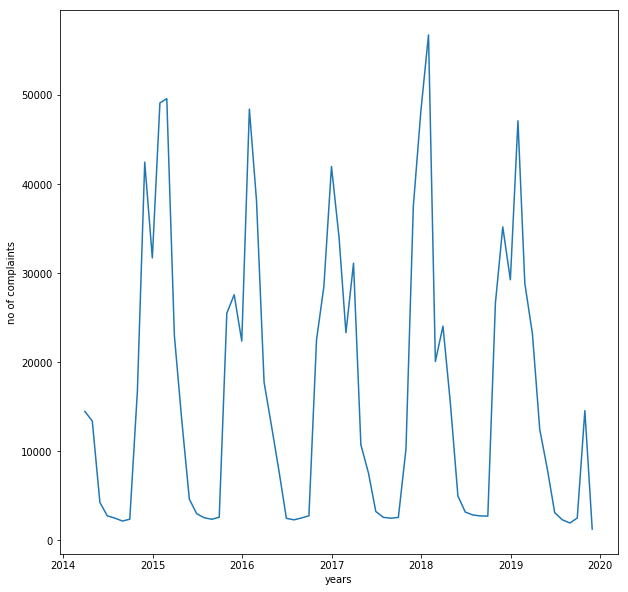

In [14]:
#data processing
columns_selected = ['complaint_type','created_date']
df_hpd_model1 = pd.read_csv('/Users/vba/Documents/311.csv',usecols=columns_selected,parse_dates = ['created_date'])
#df_hpd_model1.head(5)
#select rows with only top_complaint type HEAT HOT WATER
df_hpd_model1 = df_hpd_model1[df_hpd_model1['complaint_type']=='HEAT/HOT WATER']
#df_hpd_model1.head(5)
#create data series month wise
df_hpd_model1_top_complaint_monthly_series = pd.Series(1,index =df_hpd_model1['created_date'] )
df_hpd_model1_top_complaint_monthly_series = df_hpd_model1_top_complaint_monthly_series.resample('M').sum()
#df_hpd_model1_top_complaint_monthly_series.resample('M').sum()
df_hpd_model1_top_complaint_monthly_series.index.name = 'months'
df_hpd_model1_top_complaint_monthly_series1 = df_hpd_model1_top_complaint_monthly_series.reset_index(name='numb_complaints')
#df_hpd_model1_top_complaint_monthly_series1.columns =['months','numb_complaints']
#{'months':s.index,'numb_complaints':s.values})
print(df_hpd_model1_top_complaint_monthly_series1.head(5))

#plot the data set
plt.figure(figsize=(10,10))
x_data , y_data = (df_hpd_model1_top_complaint_monthly_series1["months"].values,df_hpd_model1_top_complaint_monthly_series1["numb_complaints"].values)
plt.plot(x_data,y_data,'-')
plt.ylabel('no of complaints')
plt.xlabel('years')
plt.show()


### 1.b.Building Models

#### Double exopnetial smoothing with damped trend Model Devlopment,caluculating accuray of model and visuvalizing it

MAE: 13827.056652487654
RMSE: 13827.056652487654


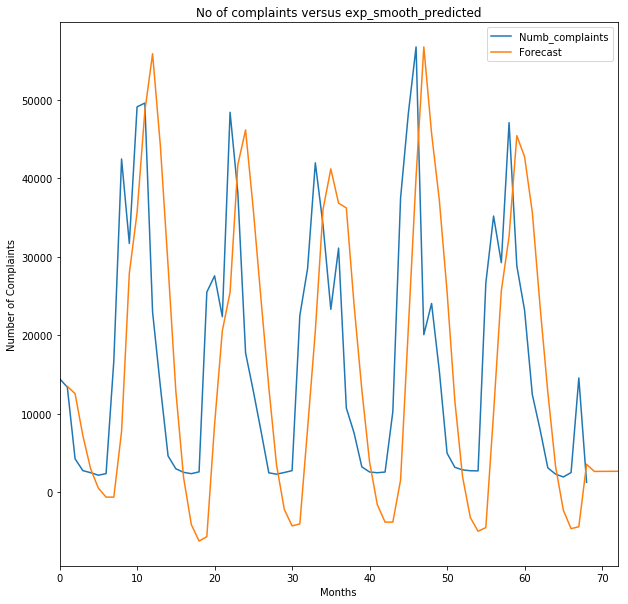

In [15]:
#Double exopnetial smoothing with damped Model 
#Double exopnetial smoothing with damped trend defing function algorithem
def exp_smooth_damped(df,extra_periods = 1,alpha = 0.4,beta = 0.4,phi= 0.9):
    #intilazing dataframe to numpy array
    d=np.array(df)
    cols=len(d)
    d=np.append(d,[np.nan]*extra_periods)
    
    #creating variables to store f,a,b values 
    f,a,b = np.full((3,cols+extra_periods),np.nan)
    
    a[0]=d[0]
    b[0]=d[1]-d[0]
    #caluculating f,a,b values
    for t in range(1,cols):
        f[t]= a[t-1]+phi*b[t-1]
        a[t]= alpha*d[t]+(1-alpha)*(a[t-1]+phi*b[t-1])
        b[t]= beta*(a[t]-a[t-1])+(1-beta)*phi*b[t-1]
    
    for t in range(cols,cols+extra_periods):
        f[t]=a[t-1]+phi*b[t-1]
        a[t]=f[t]
        b[t]=phi*b[t-1]
    #writing the predicted out put,f,a,b values to dataframe and returning it through function.
    df = pd.DataFrame.from_dict({'Numb_complaints':d,"Forecast":f,"level":a,"Trend":b,"Error":d-f})
    return df
    
#creating data frame to store numb_complaints
df_passto_func = df_hpd_model1_top_complaint_monthly_series1[["numb_complaints"]]
#calling exp_smooth_damped function and storing return value to dataframe
df1 = exp_smooth_damped(df_passto_func,extra_periods =4)
#caluculating MAE,RMSE for the model
MAE = df1['Error'].abs().mean()
print('MAE:',MAE)
RMSE = np.sqrt( df1['Error']**2).mean()
print('RMSE:',RMSE)
#df1
#plotting predicted versus actual no of complaints for the time series 
df1[['Numb_complaints','Forecast']].plot(kind='line',figsize=(10,10))
plt.title('No of complaints versus exp_smooth_predicted')
plt.ylabel('Number of Complaints')
plt.xlabel('Months')
plt.show()

#### Winsorization and Normalization Model Devlopment with rejecting outliers,caluculating accuray of model and visuvalizing it

MAE: 51.4448171612199
RMSE: 51.4448171612199


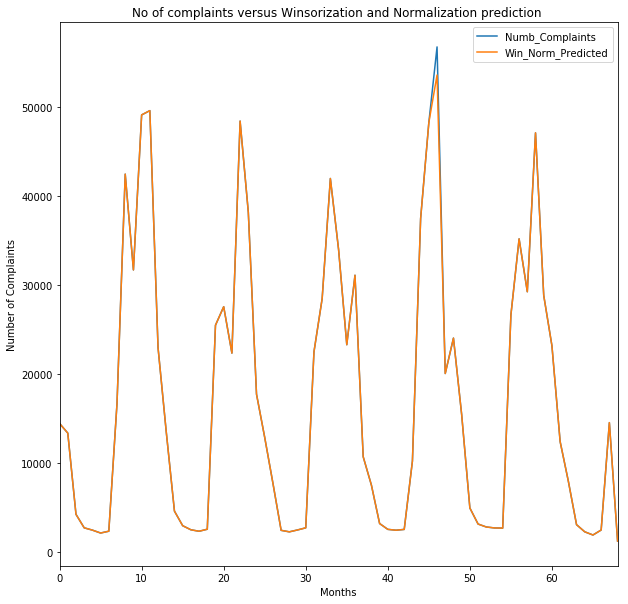

In [20]:
# The above model charts resembles the data was overfit
#Lets use beter prediction model winsorization and normalization 
np_numb_comp_array = df_hpd_model1_top_complaint_monthly_series1[["numb_complaints"]].values
np_numb_comp_array_mean = np_numb_comp_array.mean()
np_numb_comp_array_std= np_numb_comp_array.std()
from scipy.stats import norm
norm.cdf(np_numb_comp_array,np_numb_comp_array_mean,np_numb_comp_array_std).round(5)
np_numb_comp_array_high=norm.ppf(0.99,np_numb_comp_array_mean,np_numb_comp_array_std)
np_numb_comp_array_low=norm.ppf(0.01,np_numb_comp_array_mean,np_numb_comp_array_std)
df_hpd_model1_top_complaint_monthly_series1['Numb_Complaints']=df_hpd_model1_top_complaint_monthly_series1["numb_complaints"]
df_hpd_model1_top_complaint_monthly_series1['Predicted'] = df_hpd_model1_top_complaint_monthly_series1['Numb_Complaints'].clip(lower=np_numb_comp_array_low,upper= np_numb_comp_array_high)
df_hpd_model1_top_complaint_monthly_series1['Error']= df_hpd_model1_top_complaint_monthly_series1['Predicted'] - df_hpd_model1_top_complaint_monthly_series1['Numb_Complaints']
#Perform Exponetial somoothing forecast 
#lets caluculate mean ,std for error and predict the future outputs
df_hpd_model1_top_complaint_monthly_series1_mean=df_hpd_model1_top_complaint_monthly_series1['Error'].mean()
df_hpd_model1_top_complaint_monthly_series1_std=df_hpd_model1_top_complaint_monthly_series1['Error'].std()
#set limits wrt to predicted values with 99% confidence intervals
df_hpd_model1_top_complaint_monthly_series1_high = norm.ppf(0.85,df_hpd_model1_top_complaint_monthly_series1_mean,df_hpd_model1_top_complaint_monthly_series1_std)+df_hpd_model1_top_complaint_monthly_series1['Predicted']
df_hpd_model1_top_complaint_monthly_series1_low = norm.ppf(0.10,df_hpd_model1_top_complaint_monthly_series1_mean,df_hpd_model1_top_complaint_monthly_series1_std)+df_hpd_model1_top_complaint_monthly_series1['Predicted']
df_hpd_model1_top_complaint_monthly_series1['Win_Norm_Predicted'] = df_hpd_model1_top_complaint_monthly_series1["Numb_Complaints"].clip(lower=df_hpd_model1_top_complaint_monthly_series1_low,upper= df_hpd_model1_top_complaint_monthly_series1_high)
df_hpd_model1_top_complaint_monthly_series1.head(5)
#caluculating MAE,RMSE for the model
MAE = df_hpd_model1_top_complaint_monthly_series1['Error'].abs().mean()
print('MAE:',MAE)
RMSE = np.sqrt( df_hpd_model1_top_complaint_monthly_series1['Error']**2).mean()
print('RMSE:',RMSE)
##plotting predicted versus actual no of complaints for the time series 
df_hpd_model1_top_complaint_monthly_series1[['Numb_Complaints','Win_Norm_Predicted']].plot(kind='line',figsize=(10,10))
plt.title('No of complaints versus Winsorization and Normalization prediction ')
plt.ylabel('Number of Complaints')
plt.xlabel('Months')
plt.show()


### 2.Selecting the best model

In [21]:
# comparing accuracy of both the models using MSE ans RMSE metrics
#Accuracy metrics caluculation for  Double smoothing with damped trend
print('Double smoothing with damped trend')
MAE = df1['Error'].abs().mean()
print('MAE:',MAE)
RMSE = np.sqrt( df1['Error']**2).mean()
print('RMSE:',RMSE)
#Accuracy metrics caluculation for  Winsorization and Normalization Model
print('Winsorization and Normalization Model')
MAE = df_hpd_model1_top_complaint_monthly_series1['Error'].abs().mean()
print('MAE:',MAE)
RMSE = np.sqrt( df_hpd_model1_top_complaint_monthly_series1['Error']**2).mean()
print('RMSE:',RMSE)

Double smoothing with damped trend
MAE: 13827.056652487654
RMSE: 13827.056652487654
Winsorization and Normalization Model
MAE: 51.4448171612199
RMSE: 51.4448171612199


# 3.Conclusion

### From the above accuracy metrics caluculation and visualizations of both models, it is clear that to predict the number of future complaints Winsorization and Normalization Model is best fit with very low RMSE value and with out over fitting.


#### Scripted By:Venkat Alapati